# How to Build a Custom Search Engine
 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

  
# Step 1 - Design Your Custom Search Experience


## A) Review the Custom Search Design Process and Scope Your Project

In [2]:
### A) Review the Search Lifecycle to Scope Your Custom Search Project

C:\Users\pattyry\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


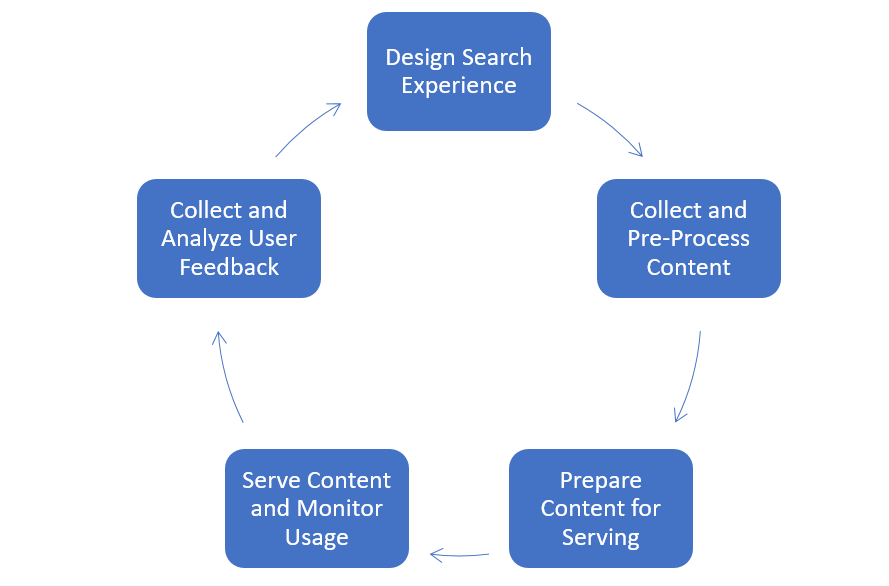

In [3]:
# Import base packages
from bs4 import BeautifulSoup
import jupyter_contrib_nbextensions
import os, glob, sys, re
import codecs
import pandas as pd
from IPython.display import Image
import IPython.html.nbextensions as nb
ext= 'https://github.com/ipython-contrib/IPython-notebook-extensions/archive/3.x.zip'
nb.install_nbextension(ext)
#os.chdir("C:\\users\\pattyry\documents\GitHub\JupyterCon2017\Services_CustomSearchExpertSystems\JupyterNotebooks")
os.getcwd()
Image(filename = "searchdesign.png", width=600, height=500)

### B) Characterize Your Target Users' Search Intents

Identifying your target user intents clearifies your target content and informs ideal unit of retrieval.

* __Navigational__: Surfing directly to a specific website 
* __Transactional__: Completing a specific task 
* __Informational__: Browsing for general information about a topic using free-form queries 


### C) Choose your Tools and Process 

The __diagram below__ describes our development process and the tools we used. 

The development and optimization process flow for our project is illustrated in gray. 
These will likely be constant across projects.

The services we leverage are in blue. 
We completed work on the steps with the solid outline in this project.

Azure Search is the foundation for our custom search experience. 
We leverage many features including custom analyzer, custom scoring, and custom synonyms. 
We complement these services with custom scripts to iteratively optimize and measure our search experience. 


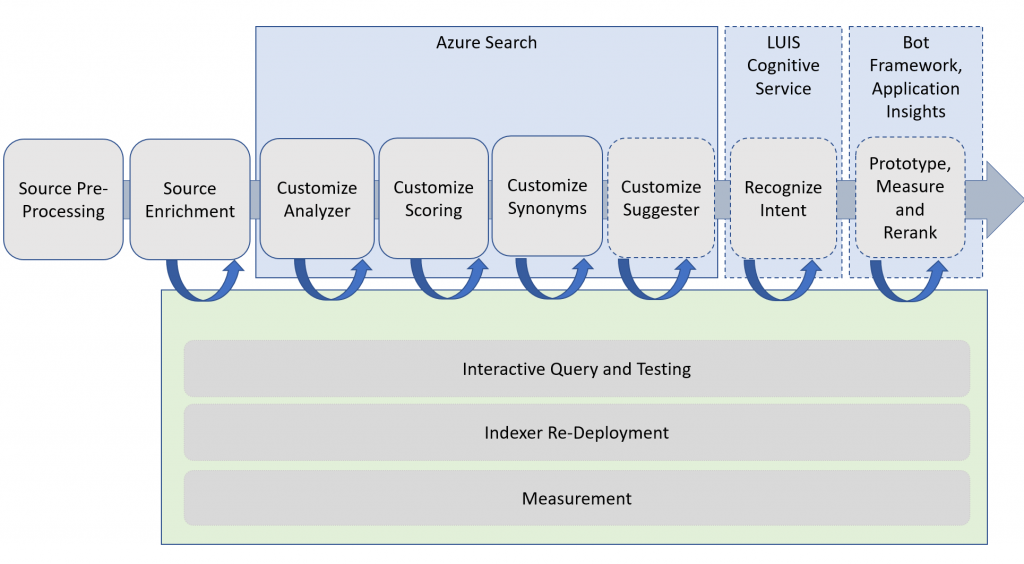

In [4]:
Image(filename = "toolsandprocess.png", width=700, height=500)

# Step 2 - Collect, Clean and Augment Content


## A) Collect Relevant Documents and Decide Content Structure

**Note: **The following example uses a few sample pages from the [University of Cornell US Tax Code](https://www.law.cornell.edu/uscode/text/26). 
This tax code is structured in a logical navigation sequence leading to the final content pages. 

Consider the sample page in the picture below. Two options are possible:
- The full page is to be considered as one unit (useful if the objective is to locate a page)
- Content under each highlighted header is a separate unit (useful if the objective is to locate specific answers)
![](sample_page.png?raw=true)


## B) Collect Relevant Documents and Decide Content Structure

Parse and extract content fields, augment with keyphrases

Choose the __*unit of retrieval*__, i.e., the unit of content that will be indexed and retrieved separately in the desired search experience. 


### - Example of parsing a content page and extract the following structural fields

* Chapter title
* Section title
* Subsection title
* Content text
* Content key phrases

In [5]:

# Let's explore one content page
html = '../sample/html/1.1.1.1.1.1.html'
page = codecs.open(html, 'r', encoding='utf-8')
# Extract page contents
soup = BeautifulSoup(page.read(), 'html.parser')

The navigation path titles (appearing at the top of the page) are included in the HTML page under {'class': 'breadcrumb'}. Example:

<ol class="breadcrumb" itemprop="breadcrumb"><li><a href="/uscode/text" title="United States Code">U.S. Code</a> › <a href="/uscode/text/26" rel="usc_sup_01_26" title="Title 26 - INTERNAL REVENUE CODE">Title 26</a> › <a href="/uscode/text/26/subtitle-A" rel="usc_sup_01_26_10_A" title="Subtitle A - Income Taxes">Subtitle A</a> › <a href="/uscode/text/26/subtitle-A/chapter-1" rel="usc_sup_01_26_10_A_20_1" title="Chapter 1 - NORMAL TAXES AND SURTAXES">Chapter 1</a> › <a href="/uscode/text/26/subtitle-A/chapter-1/subchapter-A" rel="usc_sup_01_26_10_A_20_1_30_A" title="Subchapter A - Determination of Tax Liability">Subchapter A</a> › <a href="/uscode/text/26/subtitle-A/chapter-1/subchapter-A/part-I" rel="usc_sup_01_26_10_A_20_1_30_A_40_I" title="Part I - TAX ON INDIVIDUALS">Part I</a> › § 1</li></ol>

In [6]:
# The navigation path titles are included in {'class': 'breadcrumb'}
# Following is an example:
titles = soup.find('ol', {'class': 'breadcrumb'}).findAll('a')
#print('HTML source: %s' % titles)

In [7]:
# Extract title texts
for title in titles:
    print(title.get('title'))

United States Code
Title 26 - INTERNAL REVENUE CODE
Subtitle A - Income Taxes
Chapter 1 - NORMAL TAXES AND SURTAXES
Subchapter A - Determination of Tax Liability
Part I - TAX ON INDIVIDUALS


Ignore first two lines in titles as they are repeated. 
Use the following definitions for chapter, section and subsection titles:

- Chapter title: Lines 2 and 3, e.g., Income Taxes - NORMAL TAXES AND SURTAXES
- Section title: All remaining lines in titles, e.g., Determination of Tax Liability - TAX ON INDIVIDUALS
- Subsection title: Use current page title as the base subsection title

In [8]:
# Extract chapter, section and subsection titles
chapter_title    = ' - '.join([x.get('title').split('-')[1].strip() for x in titles[2:4]])
section_title    = ' - '.join([x.get('title').split('-')[1].strip() for x in titles[4:]])
subsection_title = soup.find(id='page-title').text.split('-')[1].strip()

print('Chapter title   : %s' % chapter_title)
print('Section title   : %s' % section_title)
print('Subsection title: %s' % subsection_title)

Chapter title   : Income Taxes - NORMAL TAXES AND SURTAXES
Section title   : Determination of Tax Liability - TAX ON INDIVIDUALS
Subsection title: Tax imposed


####  Additional Resources:  Utility Functions for Text Processing

In [9]:
# Strip non-ascii characters that break the overlap check
def strip_non_ascii(s):
    s = (c for c in s if 0 < ord(c) < 255)
    s = ''.join(s)
    return s

# Clean text: remove newlines, compact spaces, strip non_ascii, etc.
def clean_text(text, lowercase=False, nopunct=False):
    # Convert to lowercase
    if lowercase:
        text = text.lower()

    # Remove punctuation
    if nopunct:
        puncts = string.punctuation
        for c in puncts:
            text = text.replace(c, ' ')

    # Strip non-ascii characters
    text = strip_non_ascii(text)
    
    # Remove newlines - Compact and strip whitespaces
    text = re.sub('[\r\n]+', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text.strip()

## C) Extract all page content

Examine the HTML source to familiarize yourself with the structure, formatting styles, section class indicators, etc. By examining the HTML in this example, we see that the main content section appears under &lt;div&gt; tags with "class" = "section". Make sure to check for exceptions or cases with styling errors to ensure a complete extracton of the content of interest.


In [10]:
# Get content from all subsections in page at once
def get_content_all(soup):
    section = soup.find("div", { "class" : "section" })
    section_text = ''
    
    # If page is empty, return
    if section == None:
        return section_text
    
    divs = section.findAll('div')
    for div in divs:
        # Do not include'sourceCredit' or 'section inline'
        if div.get('class')[0] != 'sourceCredit':
            # Fix a formatting issue causing some text to be collated when extracted
            for sp in div.findAll("span", { "class" : "chapeau" }):
                sp.replaceWith('<sp>' + sp.text)
            section_text += div.text.replace('<sp>', ' ')
    
    # Clean text, do not convert to lowercase or remove punctuation (default)
    section_text = clean_text(section_text, lowercase=False, nopunct=False)
    
    return section_text

In [11]:
content = get_content_all(soup)
#print('Content text:\n%s' % content)

### i) Keyphrase extraction
Let's extract keyphrases from the page content and examine the results. 


#### ii) Review keyphrase extraction packages
Many keyphrase extraction algorithms and implementations are available 
Check out the [Text processing portal](http://textprocessing.org/tag/keyphrase-extraction) for some examples.)  
The following example uses the RAKE algorithm implementation from [https://github.com/aneesha/RAKE](https://github.com/aneesha/RAKE). 
The base rake.py script is included for convenience (turning off *test* mode).

#### iii) Remove Stopwords, Order Keyphrases by length
We'll use the stopwords list file *SmartStoplist.txt* as the base list, and add some of the common words found in the tax code text as stopwords, such as *paragraph, subparagraph, clause, section, subsection*.  The custom list is included in the file *SmartStoplist_extended.txt*.

In [12]:
stoplist_file = 'SmartStoplist_extended.txt'
keyphrases = get_keyphrases_rake(content, stoplist_path=stoplist_file, min_score=3)

print('Number of keyphrases = %d' % len(keyphrases))

iterator = keyphrases[:10]

for keyphrase in iterator:
    print('%s -> %f' % keyphrase)
    

NameError: name 'get_keyphrases_rake' is not defined


## 4) Put it all together - Parse, process and prepare all content pages for indexing in Step 3


In [ ]:
    mode = 'full page'


In [ ]:
def parse_contents(hfile, mode='full_page', stoplist_path=None, min_score=1):
    global df
    infile  = os.path.basename(hfile)
    print('Processing %s' % infile)
    
        # Parse and extract title and sections of interest
    page = codecs.open(hfile, 'r', encoding='utf-8')
    soup  = BeautifulSoup(page.read(), 'html.parser')
    
    # The navigation path titles are included in {'class': 'breadcrumb'}
    titles = soup.find('ol', {'class': 'breadcrumb'}).findAll('a')
    
    
        # Check if section title is valid - Handle exception cases
    try:
        section_title    = ' - '.join([x.get('title').split('-')[1].strip() for x in titles[4:]])
    except:
        section_title    = ' - '.join([x.get('title').strip() for x in titles[4:]])

    # Use page title as the base subsection title
    subsection_title = soup.find(id='page-title').text.split('-')[1].strip()

    # Option #1 - Extract all page content as one document
    if mode == 'full_page':
        page_text = get_content_all(soup)
        phrases  = get_keyphrases_rake(page_text, stoplist_path=stoplist_file, min_score=min_score)
        phrases  = ', '.join(p[0] for p in phrases)
        df = df.append({'File'           : infile, 
                        'ChapterTitle'   : chapter_title.replace('\r', ''),
                        'SectionTitle'   : section_title.replace('\r', ''),
                        'SubsectionTitle': subsection_title.replace('\r', ''),
                        'SubsectionText' : page_text.replace('\r', ''),
                        'Keywords'       : phrases.replace('\r', '')},
                        ignore_index=True)    


Loop on all content pages in the 'sample' folder. Parse and process content. Save extracted content fields in Excel file to be used for indexing in step #2.

In [ ]:
INDIR  = '../sample/html'
OUTDIR = '../sample'

# Select parsing option: Option #1 (FULL_PAGE), Option #2 (SPLIT_PAGE), or both
FULL_PAGE  = True
SPLIT_PAGE = False

if not os.path.exists(OUTDIR):
  os.makedirs(OUTDIR)

# Dataframe to keep all extracted content fields
df = pd.DataFrame(columns = ['File', 'ChapterTitle', 'SectionTitle', 'SubsectionTitle',
                                     'SubsectionText', 'Keywords'])
    
# Set custom stopwords list, if needed
stoplist_file = 'SmartStoplist_extended.txt'

# Process all content pages
for infile in glob.glob(INDIR + '/*.html'):
    if FULL_PAGE:
        parse_contents(infile, mode='full_page',  stoplist_path=stoplist_file, min_score=3)
    if SPLIT_PAGE:
        parse_contents(infile, mode='split_page', stoplist_path=stoplist_file, min_score=1)

# Save extracted content for indexing in step #2
#outfile = OUTDIR + '/parsed_content.tsv'
#df.to_csv(outfile, sep='\t', index_label='Index', encoding='utf-8')    
outxlsx = OUTDIR + '/parsed_content.xlsx'
df.to_excel(outxlsx, index_label='Index', encoding='utf-8') 

In [ ]:
df.head(3)

##### The content is now ready for indexing in step #3



# Step 3 - Create Your Search Index Using Azure Search

- Define new index structure
- Create Azure Search index
- Upload and index parsed content from step 1
- Optional: Simple management of Azure Search index

In [15]:
# Import base packages
import requests
import json
import csv
import datetime
import pytz
import calendar
import os
import pyexcel as pe


### A) First, initialize Azure Search configuration parameters to be used for index creation

In [67]:
# This is the service you've already created in Azure Portal
serviceName = 'azuresearch2017' #your azure search account name

# This is the index you've already created in Azure Portal or via the azsearch_mgmt.py script
indexName = 'sampletaxcode'

# Set your service API key, either via an environment variable or enter it below
#apiKey = os.getenv('SEARCH_KEY_DEV', '')
apiKey = 'your key'
apiVersion = '2016-09-01' #keep this value

Set the path to the parsed content file from step 1, and define a basic mapping of the input fields to the desired target field names in the new index. Input and output field names do not need to be the same. However, the target names should match the index definition in getIndexDefinition().

In [16]:
# Input parsed content Excel file, e.g., output of step #1 in
# https://github.com/CatalystCode/CustomSearch/tree/master/JupyterNotebooks/1-content_extraction.ipynb
inputfile = os.path.join(os.getcwd(), '../sample/parsed_content.xlsx')

# Define fields mapping from Excel file column names to search index field names (except Index)
# Change this mapping to match your content fields and rename output fields as desired
# Search field names should match their definition in getIndexDefinition()
fields_map = [ ('File'            , 'File'),
               ('ChapterTitle'    , 'ChapterTitle'),
               ('SectionTitle'    , 'SectionTitle'),
               ('SubsectionTitle' , 'SubsectionTitle'),
               ('SubsectionText'  , 'SubsectionText'),
               ('Keywords'        , 'Keywords') ]

### B) Now, let's define the structure of the new index to be created. 
In this example, all titles, content text and keywords fields are full-text searchable. Queries will use all searchable fields by default to retrieve a ranked list of results.
For more details, refer to Create an Azure Search Index.

In [61]:
# Fields: Index	File	ChapterTitle	SectionTitle	SubsectionTitle		SubsectionText	Keywords
def getIndexDefinition():
    return {
        "name": indexName,  
        "fields": [
        {"name": "Index", "type": "Edm.String", "key": True, "retrievable": True, "searchable": False, "filterable": False, "sortable": True, "facetable": False},
        {"name": "File", "type": "Edm.String", "retrievable": True, "searchable": False, "filterable": True, "sortable": True, "facetable": False},
        {"name": "ChapterTitle", "type": "Edm.String", "retrievable": True, "searchable": True, "filterable": True, "sortable": True, "facetable": True},
        {"name": "SectionTitle", "type": "Edm.String", "retrievable": True, "searchable": True, "filterable": True, "sortable": False, "facetable": True},
        {"name": "SubsectionTitle", "type": "Edm.String", "retrievable": True, "searchable": True, "filterable": True, "sortable": True, "facetable": False},
        {"name": "SubsectionText", "type": "Edm.String", "retrievable": True, "searchable": True, "filterable": False, "sortable": False, "facetable": False, "analyzer": "en.microsoft"},
        {"name": "Keywords", "type": "Edm.String", "retrievable": True, "searchable": True, "filterable": False, "sortable": False, "facetable": False, "analyzer": "en.microsoft"}
        ]
    }

### C) Now, let's create helper functions for basic REST API operations

In [62]:
def getServiceUrl():
    return 'https://' + serviceName + '.search.windows.net'

def getMethod(servicePath):
    headers = {'Content-type': 'application/json', 'api-key': apiKey}
    r = requests.get(getServiceUrl() + servicePath, headers=headers)
    #print(r.text)
    return r

def postMethod(servicePath, body):
    headers = {'Content-type': 'application/json', 'api-key': apiKey}
    r = requests.post(getServiceUrl() + servicePath, headers=headers, data=body)
    #print(r, r.text)
    return r


### Simple index management functions
* Create a new index
* Delete an existing index
* Check if index exists

In [63]:
def createIndex():
    indexDefinition = json.dumps(getIndexDefinition())  
    servicePath = '/indexes/?api-version=%s' % apiVersion
    r = postMethod(servicePath, indexDefinition)
    #print r.text
    if r.status_code == 201:
       print('Index %s created' % indexName)   
    else:
       print('Failed to create index %s' % indexName)
       exit(1)

def deleteIndex():
    servicePath = '/indexes/%s?api-version=%s&delete' % (indexName, apiVersion)
    headers = {'Content-type': 'application/json', 'api-key': apiKey}
    r = requests.delete(getServiceUrl() + servicePath, headers=headers)
    #print(r.text)

def getIndex():
    servicePath = '/indexes/%s?api-version=%s' % (indexName, apiVersion)
    r = getMethod(servicePath)
    if r.status_code == 200:  
       return True
    else:
       return False

#### Helper functions to fetch one or more documents from the parsed content file

Note: In this exercise, a *document* corresponds to one row from the parsed content Excel file.

In [64]:
def getDocumentObject():   
    valarry = []
    cnt = 1
    records = pe.iget_records(file_name=inputfile)
    for row in records:
        outdict = {}
        outdict['@search.action'] = 'upload'

        if (row[fields_map[0][0]]):
            outdict['Index'] = str(row['Index'])
            for (in_fld, out_fld) in fields_map:
                outdict[out_fld]  = row[in_fld]
        valarry.append(outdict)
        cnt+=1

    return {'value' : valarry}

def getDocumentObjectByChunk(start, end):   
    valarry = []
    cnt = 1
    records = pe.iget_records(file_name=inputfile)
    for i, row in enumerate(records):
        if start <= i < end:
            outdict = {}
            outdict['@search.action'] = 'upload'

            if (row[fields_map[0][0]]):
                outdict['Index'] = str(row['Index'])
                for (in_fld, out_fld) in fields_map:
                    outdict[out_fld]  = row[in_fld]
            valarry.append(outdict)
            cnt+=1

    return {'value' : valarry}

#### Main functions to upload and index documents in Azure Search

Three methods are provided:
- Upload all documents (rows) at once
- Upload documents in chunks
- Upload one document at a time

**Note:** The method choice depends on the content size and whether it would fit in one or more REST request. 

In [65]:
# Upload content for indexing in one request if content is not too large
def uploadDocuments():
    documents = json.dumps(getDocumentObject())
    servicePath = '/indexes/' + indexName + '/docs/index?api-version=' + apiVersion
    r = postMethod(servicePath, documents)
    if r.status_code == 200:
        print('Success: %s' % r)   
    else:
        print('Failure: %s' % r.text)
        exit(1)

# Upload content for indexing in chunks if content is too large for one request
def uploadDocumentsInChunks(chunksize):
    records = pe.iget_records(file_name=inputfile)
    cnt  = 0
    for row in records:
        cnt += 1

    for chunk in range(cnt/chunksize + 1):
        print('Processing chunk number %d ...' % chunk)
        start = chunk * chunksize
        end   = start + chunksize
        documents = json.dumps(getDocumentObjectByChunk(start, end))
        servicePath = '/indexes/' + indexName + '/docs/index?api-version=' + apiVersion
        r = postMethod(servicePath, documents)
        if r.status_code == 200:
            print('Success: %s' % r)   
        else:
            print('Failure: %s' % r.text)
    return

# Upload content for indexing one document at a time
def uploadDocumentsOneByOne():
    records = pe.iget_records(file_name=inputfile)
    valarry = []
    for i, row in enumerate(records):
        outdict = {}
        outdict['@search.action'] = 'upload'

        if (row[fields_map[0][0]]):
            outdict['Index'] = str(row['Index'])
            for (in_fld, out_fld) in fields_map:
                outdict[out_fld]  = row[in_fld]
            valarry.append(outdict)

        documents = json.dumps({'value' : valarry})
        servicePath = '/indexes/' + indexName + '/docs/index?api-version=' + apiVersion
        r = postMethod(servicePath, documents)
        if r.status_code == 200:
            print('%d Success: %s' % (i,r))   
        else:
            print('%d Failure: %s' % (i, r.text))
            exit(1)

#### Helper functions to check and query an index

In [66]:
def printDocumentCount():
    servicePath = '/indexes/' + indexName + '/docs/$count?api-version=' + apiVersion   
    getMethod(servicePath)

def sampleQuery(query, ntop=3):
    servicePath = '/indexes/' + indexName + '/docs?api-version=%s&search=%s&$top=%d' % \
        (apiVersion, query, ntop)
    getMethod(servicePath)

### Specify your Azure Search Subscription


### Create and Upload Your Index!

Now let's create the index, or delete and re-create the index if it exists, then upload all parsed documents in chunks. The small sample can be uploaded all at once, but the full tax code content would require multiple requests.

In [69]:
# Choose upload method to be used. Options: 'all', chunks' or 'one'
upload_method     = 'all'
upload_chunk_size = 5000

# Create index if it does not exist
if not getIndex():
    createIndex()    
else:
   # ans = raw_input('Index %s already exists ... Do you want to delete it? [Y/n]' % indexName)
   # if ans.lower() == 'y':
        deleteIndex()
        print('Re-creating index %s ...' % indexName)
        createIndex()
   # else:
   #     print('Index %s is not deleted ... New content will be added to existing index' % indexName)

if upload_method == 'all':
    uploadDocuments()
elif upload_method == 'chunks':
    uploadDocumentsInChunks(upload_chunk_size)
else:
    uploadDocumentsOneByOne()
    


Index sampletaxcode created
Success: <Response [200]>


#### The content is now ready for interactive or batch queries, as demonstrated in step #4


# Step 4 - Interactive Query


### A) Optional configuration parameters to alter the search query request.

In [70]:
# Retrieval options to alter the query results
SEARCHFIELDS = None                            # use all searchable fields for retrieval
#SEARCHFIELDS = 'Keywords, SubsectionText'     # use selected fields only for retrieval
FUZZY = False                                  # enable fuzzy search (check API for details)
NTOP  = 5                                      # uumber of results to return

### B) Helper functions for basic REST API operations

In [71]:
def getServiceUrl():
    return 'https://' + serviceName + '.search.windows.net'

def getMethod(servicePath):
    headers = {'Content-type': 'application/json', 'api-key': apiKey}
    r = requests.get(getServiceUrl() + servicePath, headers=headers)
    #print(r, r.text)
    return r

def postMethod(servicePath, body):
    headers = {'Content-type': 'application/json', 'api-key': apiKey}
    r = requests.post(getServiceUrl() + servicePath, headers=headers, data=body)
    #print(r, r.text)
    return r


### C) Helper functions to submit a search query interactively or in batch


In [72]:
def submitQuery(query, fields=None, ntop=10, fuzzy=False):
    servicePath = '/indexes/' + indexName + '/docs?api-version=%s&search=%s&$top=%d' % \
        (apiVersion, query, ntop)
    if fields != None:
        servicePath += '&searchFields=%s' % fields
    if fuzzy:
        servicePath += '&queryType=full'
    
    # Submit GET request
    r = getMethod(servicePath)
    if r.status_code != 200:
        print('Failed to retrieve search results')
        print(r, r.text)
        return
    
    # Parse and report search results
    docs = json.loads(r.text)['value']
    print('Number of search results = %d\n' % len(docs))
    for i, doc in enumerate(docs):
        print('Results# %d' % (i+1))
        print('Chapter title   : %s' % doc['ChapterTitle'].encode('utf8'))
        print('Section title   : %s' % doc['SectionTitle'].encode('utf8'))
        print('Subsection title: %s' % doc['SubsectionTitle'].encode('utf8'))
        print('%s\n' % doc['SubsectionText'].encode('utf8'))
        
def submitBatchQuery(query, fields=None, ntop=10, fuzzy=False):
    servicePath = '/indexes/' + indexName + '/docs?api-version=%s&search=%s&$top=%d' % \
        (apiVersion, query, ntop)
    if fields != None:
        servicePath += '&searchFields=%s' % fields
    if fuzzy:
        servicePath += '&queryType=full'

    # Submit GET request
    r = getMethod(servicePath)
    if r.status_code != 200:
        print('Failed to retrieve search results')
        print(query, r, r.text)
        return {}

    # Return search results
    docs = json.loads(r.text)['value']
    return docs

### D) Submit a query and return the results

In [73]:
query = 'what is the tax bracket for married couple filing separately'
if query != '':
    # Submit query to Azure Search and retrieve results
    searchFields = SEARCHFIELDS
    submitQuery(query, fields=searchFields, ntop=NTOP)

Number of search results = 5

Results# 1
Chapter title   : b'Income Taxes - NORMAL TAXES AND SURTAXES'
Section title   : b'Determination of Tax Liability - CREDITS AGAINST TAX - Nonrefundable Personal Credits'
Subsection title: b'Credit for the elderly and the permanently and totally disabled'
b'\xc2\xa722. Credit for the elderly and the permanently and totally disabled (a) General rule In the case of a qualified individual, there shall be allowed as a credit against the tax imposed by this chapter for the taxable year an amount equal to 15 percent of such individuals section 22 amount for such taxable year. In the case of a qualified individual, there shall be allowed as a credit against the tax imposed by this chapter for the taxable year an amount equal to 15 percent of such individuals section 22 amount for such taxable year. (b) Qualified individual For purposes of this section, the term qualified individual means any individual (1) who has attained age 65 before the close of the 